In [776]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil.parser
import math
from datetime import date
from datetime import datetime, timedelta
from vega_datasets import data
import altair as alt
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')
import seaborn as sns
import re

In [777]:
today = date.today()
print(today)

2020-06-26


In [778]:
# source: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
ecdc = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", encoding = "utf-8")
ecdc.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp
0,26/06/2020,26,6,2020,460,36,Afghanistan,AF,AFG,38041757.0,Asia
1,25/06/2020,25,6,2020,234,21,Afghanistan,AF,AFG,38041757.0,Asia
2,24/06/2020,24,6,2020,338,20,Afghanistan,AF,AFG,38041757.0,Asia
3,23/06/2020,23,6,2020,310,17,Afghanistan,AF,AFG,38041757.0,Asia
4,22/06/2020,22,6,2020,409,12,Afghanistan,AF,AFG,38041757.0,Asia


In [779]:
#excluding NANs
countries_list = ecdc[ecdc['countryterritoryCode'].notnull()]['countryterritoryCode'].unique()


In [780]:
len(countries_list)

209

# configure date to be datetime

In [781]:
ecdc['parsed_date'] = [re.sub(r'(\d\d)\/(\d\d)\/(\d\d\d\d)','\g<3>-\g<2>-\g<1>', date) for date in ecdc['dateRep']]
ecdc.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,parsed_date
0,26/06/2020,26,6,2020,460,36,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-26
1,25/06/2020,25,6,2020,234,21,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-25
2,24/06/2020,24,6,2020,338,20,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-24
3,23/06/2020,23,6,2020,310,17,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-23
4,22/06/2020,22,6,2020,409,12,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-22


In [782]:
ecdc['parsed_date'] = [datetime.strptime(date, '%Y-%m-%d') for date in ecdc['parsed_date']]

In [783]:
# check whether latest date is today
ecdc['parsed_date'][0] == datetime.strptime(str(today),'%Y-%m-%d')

True

# Classify countries

In [784]:
moredouble = '01_moredouble'
more = '02_more'
samesame ='03_samesame'
less = '04_less'
lesshalf = '05_lesshalf'
zerozero ='06_zerozero'

In [785]:
threshold_samesame = 7

In [786]:
list_country_dicts = []

for country in countries_list:
    country_dict = {}
    #filter dataframe for one specific country at a time
    filtered_aggregates = ecdc[ecdc['countryterritoryCode']==country]
    country_dict['country_ISO'] = country
    #filter country-specific-dataframe to only contain the last seven days ("this week")
    seven_days_ago = today-timedelta(7)
    country_dict['today'] = today
    country_dict['seven_days_ago'] = seven_days_ago
    filtered_aggregates_this_week = filtered_aggregates[(filtered_aggregates['parsed_date']<=today) & (filtered_aggregates['parsed_date']>seven_days_ago)]
    cases_this_week = filtered_aggregates_this_week['cases'].sum()
    country_dict['cases_this_week']= cases_this_week
    #filter country-specific-dataframe to only contain the previous seven days ("last week")    
    fourteen_day_ago = today-timedelta(14)
    country_dict['fourteen_days_ago'] = fourteen_day_ago
    filtered_aggregates_last_week = filtered_aggregates[(filtered_aggregates['parsed_date']<=seven_days_ago) &(filtered_aggregates['parsed_date']>fourteen_day_ago)]
    cases_last_week = filtered_aggregates_last_week['cases'].sum()
    country_dict['cases_last_week']= cases_last_week
    # classify country -- verbal description: see README.md
    if (cases_last_week>0)&(cases_this_week > (cases_last_week * 2)):
        country_dict['trend_class'] = moredouble
    elif cases_this_week >= (cases_last_week+threshold_samesame):
        country_dict['trend_class'] = more
    elif (cases_last_week == 0)& (cases_this_week !=0):
        country_dict['trend_class'] = more
    elif (cases_last_week==0)&(cases_this_week==0):
        country_dict['trend_class'] = zerozero
    elif (cases_this_week == cases_last_week):
        country_dict['trend_class'] = samesame
    elif (cases_this_week == 0)&(cases_last_week != 0):
        country_dict['trend_class'] = lesshalf
    elif cases_last_week+threshold_samesame > cases_this_week > cases_last_week -threshold_samesame:
        country_dict['trend_class'] = samesame
    elif cases_this_week < cases_last_week/2:
        country_dict['trend_class'] = lesshalf
    elif cases_this_week <= cases_last_week-threshold_samesame:
        country_dict['trend_class'] = less
    else:
        country_dict['trend_class'] = 'youMISSEDsth'

    # add it all to the list of country dicts
    list_country_dicts.append(country_dict)

/Users/grueng/.virtualenvs/dw_data/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  if sys.path[0] == '':
/Users/grueng/.virtualenvs/dw_data/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


In [787]:
two_week_trend = pd.DataFrame(list_country_dicts)
two_week_trend.head()

,cases_last_week,cases_this_week,country_ISO,fourteen_days_ago,seven_days_ago,today,trend_class
0,4642,2643,AFG,2020-06-12,2020-06-19,2020-06-26,04_less
1,403,404,ALB,2020-06-12,2020-06-19,2020-06-26,03_samesame
2,796,1060,DZA,2020-06-12,2020-06-19,2020-06-26,02_more
3,3,0,AND,2020-06-12,2020-06-19,2020-06-26,05_lesshalf
4,37,42,AGO,2020-06-12,2020-06-19,2020-06-26,03_samesame


In [788]:
two_week_trend['trend_class'].value_counts()

02_more          69
04_less          49
06_zerozero      27
01_moredouble    23
05_lesshalf      21
03_samesame      20
Name: trend_class, dtype: int64

# Check for unclassified countries and other classes

In [789]:
len(two_week_trend[two_week_trend['trend_class']=='youMISSEDsth'])

0

In [790]:
two_week_trend[two_week_trend['trend_class']=='04_less']

,cases_last_week,cases_this_week,country_ISO,fourteen_days_ago,seven_days_ago,today,trend_class
0,4642,2643,AFG,2020-06-12,2020-06-19,2020-06-26,04_less
17,4841,3725,BLR,2020-06-12,2020-06-19,2020-06-26,04_less
35,2690,2402,CAN,2020-06-12,2020-06-19,2020-06-26,04_less
41,278,207,CHN,2020-06-12,2020-06-19,2020-06-26,04_less
43,48,37,COM,2020-06-12,2020-06-19,2020-06-26,04_less
53,309,292,DNK,2020-06-12,2020-06-19,2020-06-26,04_less
57,4657,4059,ECU,2020-06-12,2020-06-19,2020-06-26,04_less
58,10711,10693,EGY,2020-06-12,2020-06-19,2020-06-26,04_less
63,137,120,SWZ,2020-06-12,2020-06-19,2020-06-26,04_less
64,1284,1221,ETH,2020-06-12,2020-06-19,2020-06-26,04_less


In [791]:
two_week_trend[two_week_trend['trend_class']=='03_samesame']

,cases_last_week,cases_this_week,country_ISO,fourteen_days_ago,seven_days_ago,today,trend_class
1,403,404,ALB,2020-06-12,2020-06-19,2020-06-26,03_samesame
4,37,42,AGO,2020-06-12,2020-06-19,2020-06-26,03_samesame
19,2,1,BLZ,2020-06-12,2020-06-19,2020-06-26,03_samesame
21,3,2,BMU,2020-06-12,2020-06-19,2020-06-26,03_samesame
22,5,3,BTN,2020-06-12,2020-06-19,2020-06-26,03_samesame
33,3,1,KHM,2020-06-12,2020-06-19,2020-06-26,03_samesame
39,6,9,TCD,2020-06-12,2020-06-19,2020-06-26,03_samesame
49,1,1,CUW,2020-06-12,2020-06-19,2020-06-26,03_samesame
50,10,7,CYP,2020-06-12,2020-06-19,2020-06-26,03_samesame
62,12,7,EST,2020-06-12,2020-06-19,2020-06-26,03_samesame


In [792]:
two_week_trend[two_week_trend['trend_class']=='02_more'].head(30)

,cases_last_week,cases_this_week,country_ISO,fourteen_days_ago,seven_days_ago,today,trend_class
2,796,1060,DZA,2020-06-12,2020-06-19,2020-06-26,02_more
6,0,39,ATG,2020-06-12,2020-06-19,2020-06-26,02_more
8,4029,4549,ARM,2020-06-12,2020-06-19,2020-06-26,02_more
10,106,167,AUS,2020-06-12,2020-06-19,2020-06-26,02_more
11,191,276,AUT,2020-06-12,2020-06-19,2020-06-26,02_more
12,2447,3523,AZE,2020-06-12,2020-06-19,2020-06-26,02_more
14,3161,3651,BHR,2020-06-12,2020-06-19,2020-06-26,02_more
15,24240,24314,BGD,2020-06-12,2020-06-19,2020-06-26,02_more
18,637,659,BEL,2020-06-12,2020-06-19,2020-06-26,02_more
20,292,420,BEN,2020-06-12,2020-06-19,2020-06-26,02_more


# Count countries per category

In [793]:
current_status = two_week_trend['trend_class'].value_counts().rename_axis('trend_class').reset_index(name='country_count_on_today')

In [794]:
current_status.sort_values(by='trend_class')

,trend_class,country_count_on_today
3,01_moredouble,23
0,02_more,69
5,03_samesame,20
1,04_less,49
4,05_lesshalf,21
2,06_zerozero,27


In [795]:
current_status['country_count_on_today'].sum()

209

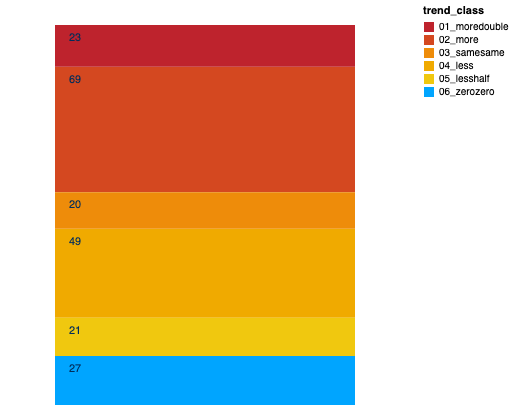

In [796]:
chart = alt.Chart(current_status).mark_bar(opacity=1,width=300).encode(
    y=alt.Y('sum(country_count_on_today):Q', stack='zero', axis=None),
    color=alt.Color('trend_class:N',scale=alt.Scale(domain=[moredouble, more,samesame,less, lesshalf,zerozero],range=["#BE232D","#D44820","#EE8C0A","#F0AA00","#F0C80F","#00A5FF"]))
    #color=alt.Color('trend_class:N',scale=alt.Scale(domain=['01_moredouble', '02_more','03_samesame','04_less', '05_lesshalf','06_zerozero'],range=["#BE232D","#EE8C0A","#F0C80F","#00A5FF","#002D5A","#96BE00"]))
).properties(
    width=400, 
    height=400
)

numbers_labels = alt.Chart(current_status).mark_text(dx=-130, dy=13, color='#002D5A').encode(
    y=alt.Y('sum(country_count_on_today):Q', stack = 'zero', axis = None),
    detail='trend_class:N',
    text=alt.Text('sum(country_count_on_today):Q', format='.0f'),
)

labeled_chart = chart + numbers_labels
labeled_chart.configure_view(
   strokeOpacity=0
)


# List countries in each class

In [797]:
trend_classes = ['01_moredouble', '02_more', '03_samesame', '04_less', '05_lesshalf', '06_zerozero']

In [798]:
two_week_trend.head()

,cases_last_week,cases_this_week,country_ISO,fourteen_days_ago,seven_days_ago,today,trend_class
0,4642,2643,AFG,2020-06-12,2020-06-19,2020-06-26,04_less
1,403,404,ALB,2020-06-12,2020-06-19,2020-06-26,03_samesame
2,796,1060,DZA,2020-06-12,2020-06-19,2020-06-26,02_more
3,3,0,AND,2020-06-12,2020-06-19,2020-06-26,05_lesshalf
4,37,42,AGO,2020-06-12,2020-06-19,2020-06-26,03_samesame


In [799]:
regions = pd.read_csv('data/country-and-continent-codes-list.csv', delimiter = ";")
regions.columns =(['continent', 'region', 'subregion', 'country', 'M49 code','country_ISO', 'ISO-alpha2 code', 'Other groupings'])
regions.head()

,continent,region,subregion,country,M49 code,country_ISO,ISO-alpha2 code,Other groupings
0,Asia,Southern Asia,Southern Asia,Afghanistan,4,AFG,AF,LDC LLDC
1,Europe,Southern Europe,Southern Europe,Albania,8,ALB,AL,NaN
2,Americas,Northern America,Northern America,Antarctica,10,ATA,AQ,NaN
3,Africa,Northern Africa,Northern Africa,Algeria,12,DZA,DZ,NaN
4,Oceania,Polynesia,Polynesia,American Samoa,16,ASM,AS,SIDS


In [800]:
two_week_trend = two_week_trend.merge(regions[['country_ISO', 'continent', 'country']], left_on='country_ISO', right_on='country_ISO')
two_week_trend.head()

,cases_last_week,cases_this_week,country_ISO,fourteen_days_ago,seven_days_ago,today,trend_class,continent,country
0,4642,2643,AFG,2020-06-12,2020-06-19,2020-06-26,04_less,Asia,Afghanistan
1,403,404,ALB,2020-06-12,2020-06-19,2020-06-26,03_samesame,Europe,Albania
2,796,1060,DZA,2020-06-12,2020-06-19,2020-06-26,02_more,Africa,Algeria
3,3,0,AND,2020-06-12,2020-06-19,2020-06-26,05_lesshalf,Europe,Andorra
4,37,42,AGO,2020-06-12,2020-06-19,2020-06-26,03_samesame,Africa,Angola


In [801]:
two_week_trend[two_week_trend['country'] == 'Viet Nam']

,cases_last_week,cases_this_week,country_ISO,fourteen_days_ago,seven_days_ago,today,trend_class,continent,country
201,10,10,VNM,2020-06-12,2020-06-19,2020-06-26,03_samesame,Asia,Viet Nam


In [802]:
continent_list = ['Asia', 'Africa', 'Americas', 'Europe', 'Oceania']

In [803]:
for trend_class in trend_classes:
    print('****TREND CLASS:'+ trend_class)
    trend_class_df = two_week_trend[two_week_trend['trend_class'] == trend_class]
    for continent in continent_list:
        continent_trend_class = trend_class_df[trend_class_df['continent']==continent]
        print('   ')
        print(continent+':')
        #classified_countries = []
        for country in continent_trend_class['country']:
            if country == 'Viet Nam':
                print('Vietnam, ')
            elif country == 'Russian Federation':
                print('Russia, ')
            elif country == 'State of Palestine':
                print('Palestinian territories, ')
            elif country == "Lao People's Democratic Republic" :
                print('Laos, ')
            elif country == "Syrian Arab Republic":
                print('Syria, ')
            elif country == "Czechia":
                print('Czech Republic, ')
            elif country == "United States Virgin Islands":
                print('US Virgin Islands, ')
            elif country == "Republic of Korea":
                print('South Korea, ')
            elif country == "United Republic of Tanzania":
                print('Tanzania, ')
            elif '(' in country:
                cleaned_name = re.sub(' \(\w* \w* \w*\)', '',country)
                print(cleaned_name+', ')
                
            else:
                print(country+', ')
            #classified_countries.append(country)
        #print(classified_countries)

****TREND CLASS:01_moredouble
   
Asia:
Kyrgyzstan, 
Mongolia, 
Palestinian territories, 
Syria, 
   
Africa:
Burkina Faso, 
Burundi, 
Congo, 
Madagascar, 
Malawi, 
Morocco, 
Namibia, 
   
Americas:
Argentina, 
Costa Rica, 
Jamaica, 
Paraguay, 
US Virgin Islands, 
Uruguay, 
   
Europe:
Croatia, 
Montenegro, 
Slovakia, 
   
Oceania:
Guam, 
New Zealand, 
****TREND CLASS:02_more
   
Asia:
Armenia, 
Azerbaijan, 
Bahrain, 
Bangladesh, 
India, 
Iraq, 
Israel, 
Japan, 
Kazakhstan, 
Kuwait, 
Lebanon, 
Nepal, 
Oman, 
Philippines, 
United Arab Emirates, 
Uzbekistan, 
   
Africa:
Algeria, 
Benin, 
Cameroon, 
Cabo Verde, 
Central African Republic, 
Côte d’Ivoire, 
Democratic Republic of the Congo, 
Equatorial Guinea, 
Kenya, 
Lesotho, 
Liberia, 
Libya, 
Mauritania, 
Mauritius, 
Nigeria, 
Rwanda, 
Senegal, 
South Africa, 
Togo, 
Uganda, 
Western Sahara, 
   
Americas:
Antigua and Barbuda, 
Bolivia, 
Brazil, 
Colombia, 
Dominican Republic, 
El Salvador, 
Guatemala, 
Guyana, 
Honduras, 
Mexico, 
Pana

In [804]:
for continent in continent_list:
    print(continent+':')
    continent_df = two_week_trend[two_week_trend['continent'] == continent]
    for trend_class in trend_classes:
        continent_trend_class = continent_df[continent_df['trend_class']==trend_class]
        print('   ')
        print('****TREND CLASS:'+ trend_class)
        print(continent+':')
        #classified_countries = []
        for country in continent_trend_class['country']:
            if country == 'Viet Nam':
                print('Vietnam, ')
            elif country == 'Russian Federation':
                print('Russia, ')
            elif country == 'State of Palestine':
                print('Palestinian territories, ')
            elif country == "Lao People's Democratic Republic" :
                print('Laos, ')
            elif country == "Syrian Arab Republic":
                print('Syria, ')
            elif country == "Czechia":
                print('Czech Republic, ')
            elif country == "United States Virgin Islands":
                print('US Virgin Islands, ')
            elif country == "Republic of Korea":
                print('South Korea, ')
            elif country == "United Republic of Tanzania":
                print('Tanzania, ')
            elif '(' in country:
                cleaned_name = re.sub(' \(\w* \w* \w*\)', '',country)
                print(cleaned_name+', ')
                
            else:
                print(country+', ')
            #classified_countries.append(country)
        #print(classified_countries)

Asia:
   
****TREND CLASS:01_moredouble
Asia:
Kyrgyzstan, 
Mongolia, 
Palestinian territories, 
Syria, 
   
****TREND CLASS:02_more
Asia:
Armenia, 
Azerbaijan, 
Bahrain, 
Bangladesh, 
India, 
Iraq, 
Israel, 
Japan, 
Kazakhstan, 
Kuwait, 
Lebanon, 
Nepal, 
Oman, 
Philippines, 
United Arab Emirates, 
Uzbekistan, 
   
****TREND CLASS:03_samesame
Asia:
Bhutan, 
Cambodia, 
Cyprus, 
Thailand, 
Vietnam, 
   
****TREND CLASS:04_less
Asia:
Afghanistan, 
China, 
Indonesia, 
Iran, 
Jordan, 
Maldives, 
Pakistan, 
Qatar, 
Saudi Arabia, 
Singapore, 
South Korea, 
Sri Lanka, 
Tajikistan, 
Turkey, 
Yemen, 
   
****TREND CLASS:05_lesshalf
Asia:
Georgia, 
Malaysia, 
Myanmar, 
   
****TREND CLASS:06_zerozero
Asia:
Brunei Darussalam, 
Laos, 
Timor-Leste, 
Africa:
   
****TREND CLASS:01_moredouble
Africa:
Burkina Faso, 
Burundi, 
Congo, 
Madagascar, 
Malawi, 
Morocco, 
Namibia, 
   
****TREND CLASS:02_more
Africa:
Algeria, 
Benin, 
Cameroon, 
Cabo Verde, 
Central African Republic, 
Côte d’Ivoire, 
Democrat